In [77]:
import pandas as pd
import plotly.express as px
import json
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
# Getting the working directory
cwd = os.getcwd()
print(cwd)

C:\Users\karol\Desktop\Coding\Coffee-Belt-Of-Africa\template_project\notebooks


In [7]:
# The data was downladed from https://www.fao.org/faostat/en/#data/QCL
# Open the data and do some digging
file_path = '../data/raw/FAOSTAT_data_en_4-5-2024-combined.csv'

df = pd.read_csv(file_path)


In [8]:
df.head(10)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1961,1961,t,75100.0,A,Official figure,NaN
1,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1962,1962,t,76000.0,A,Official figure,NaN
2,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1963,1963,t,85000.0,A,Official figure,NaN
3,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1964,1964,t,91200.0,A,Official figure,NaN
4,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1965,1965,t,78800.0,A,Official figure,NaN
5,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1966,1966,t,86500.0,A,Official figure,NaN
6,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1967,1967,t,93000.0,A,Official figure,NaN
7,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1968,1968,t,102000.0,A,Official figure,NaN
8,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1969,1969,t,108186.0,A,Official figure,NaN
9,QCL,Crops and livestock products,120,Cameroon,5510,Production,1640,Cocoa beans,1970,1970,t,133770.0,A,Official figure,NaN


In [10]:
# The cocoa producing countries on the cocoa belt !
df["Area"].unique()

array(['Cameroon', 'Congo', "Côte d'Ivoire",
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Ghana', 'Nigeria', 'Sao Tome and Principe', 'Sierra Leone',
       'Togo'], dtype=object)

In [13]:
# Some of the columns need to be dropped or renamed
df.columns

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note'],
      dtype='object')

In [31]:
# Dropping the columns that are not of interest and renamin some of them

new_df = df.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)','Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code',
       'Flag', 'Flag Description', 'Note', 'Unit'], inplace=False)


In [32]:
new_df.rename(columns={"Area": "Country", "Value": "Cocoa Production (tons)"}, inplace =True)

In [33]:
new_df.head()

,Country,Year,Cocoa Production (tons)
0,Cameroon,1961,75100.0
1,Cameroon,1962,76000.0
2,Cameroon,1963,85000.0
3,Cameroon,1964,91200.0
4,Cameroon,1965,78800.0


In [30]:
new_df.describe()

,Year,Cocoa Production(tons)
count,682.000000,6.820000e+02
mean,1991.500000,1.711839e+05
std,17.908665,3.475006e+05
min,1961.000000,1.000000e+02
25%,1976.000000,4.000000e+03
50%,1991.500000,1.135000e+04
75%,2007.000000,2.011250e+05
max,2022.000000,2.235043e+06


In [47]:
# Round the Cocoa Production(tons) to whole numbers for better readability
new_df["Cocoa Production (tons)"] = new_df["Cocoa Production (tons)"].round(0).astype(int)

In [48]:

new_df.head()

,Country,Year,Cocoa Production (tons)
0,Cameroon,1961,75100
1,Cameroon,1962,76000
2,Cameroon,1963,85000
3,Cameroon,1964,91200
4,Cameroon,1965,78800


In [49]:
# No missing values
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Country                  682 non-null    object
 1   Year                     682 non-null    int64 
 2   Cocoa Production (tons)  682 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 13.4+ KB


In [50]:
# The data is in long format which is good for dotabases but not good for readability and analysis

pivoted_df = new_df.pivot(index="Country", columns="Year", values="Cocoa Production (tons)")

In [51]:
pivoted_df.head(10)

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Cameroon,75100,76000,85000,91200,78800,86500,93000,102000,108186,133770,...,275000,269228,310000,344752,322248,317530,301255,280077,295000,300000
Congo,900,630,800,1100,800,877,1144,1288,1195,1344,...,5000,5000,2500,3800,3500,4500,5000,7000,16000,20000
Côte d'Ivoire,85000,110000,115000,139069,121772,149662,146640,144476,180706,179156,...,1448992,1637778,1796000,1634000,2034000,2113189,2235043,2200000,2228459,2230000
Democratic Republic of the Congo,5800,6500,5600,4800,4300,5300,4900,4500,4900,6200,...,2000,3000,6000,10200,13500,18475,22058,26337,20000,20000
Equatorial Guinea,26000,30900,33000,35100,35400,38200,33600,38000,28000,35000,...,700,892,1000,1000,1000,1000,1000,1000,600,1000
Gabon,3190,3360,3600,4000,2170,4296,4061,4751,4366,6095,...,200,203,100,100,100,100,100,100,100,100
Ghana,415200,428100,427800,580500,415800,381100,423500,327000,414300,406000,...,835466,858720,858720,858720,969300,904700,811700,800000,1047385,1108663
Nigeria,197000,182000,223000,298300,184600,267200,238000,191800,220800,304800,...,367000,329870,302066,298029,250000,270000,250000,357608,280000,280000
Sao Tome and Principe,9100,9600,7800,10700,8900,10900,10900,10600,9100,9700,...,2617,3200,3000,3001,3501,3046,3000,3000,3000,3000


In [39]:
pivoted_df.columns

Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022],
      dtype='int64', name='Year')

In [40]:
pivoted_df.index

Index(['Cameroon', 'Congo', 'Côte d'Ivoire',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Ghana', 'Nigeria', 'Sao Tome and Principe', 'Sierra Leone', 'Togo'],
      dtype='object', name='Country')

In [52]:
pivoted_df.describe()

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
mean,75607.272727,78479.090909,83528.181818,107768.090909,79074.727273,87715.363636,88904.727273,77223.090909,90812.272727,101367.727273,...,2.697114e+05,2.861050e+05,3.001260e+05,2.919370e+05,3.322320e+05,3.354718e+05,3.322185e+05,3.369202e+05,3.559585e+05,3.631603e+05
std,127329.846312,129527.865763,133358.268346,180989.033801,126804.298767,127981.166954,134478.554281,105556.773149,132485.099117,140321.576937,...,4.699139e+05,5.197525e+05,5.621232e+05,5.176907e+05,6.349452e+05,6.498279e+05,6.778139e+05,6.662511e+05,6.953912e+05,7.015001e+05
min,900.000000,630.000000,800.000000,1100.000000,800.000000,877.000000,1144.000000,1288.000000,1195.000000,1344.000000,...,2.000000e+02,2.030000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
25%,4495.000000,5640.000000,4600.000000,4400.000000,3640.000000,4917.000000,4480.500000,4895.000000,4633.000000,6147.500000,...,2.308500e+03,3.100000e+03,2.750000e+03,3.400500e+03,3.500500e+03,3.773000e+03,4.000000e+03,5.000000e+03,6.500000e+03,8.500000e+03
50%,11550.000000,11400.000000,13900.000000,17500.000000,14300.000000,16300.000000,18338.000000,20000.000000,23600.000000,27900.000000,...,1.485000e+04,1.708200e+04,1.000000e+04,1.020000e+04,1.350000e+04,1.847500e+04,1.464800e+04,1.800000e+04,1.600000e+04,2.000000e+04
75%,80050.000000,93000.000000,100000.000000,115134.500000,100286.000000,118081.000000,119820.000000,123238.000000,144446.000000,156463.000000,...,3.210000e+05,2.995490e+05,3.060330e+05,3.213905e+05,2.861240e+05,2.937650e+05,2.756275e+05,3.188425e+05,2.875000e+05,2.900000e+05
max,415200.000000,428100.000000,427800.000000,580500.000000,415800.000000,381100.000000,423500.000000,327000.000000,414300.000000,406000.000000,...,1.448992e+06,1.637778e+06,1.796000e+06,1.634000e+06,2.034000e+06,2.113189e+06,2.235043e+06,2.200000e+06,2.228459e+06,2.230000e+06


In [56]:
# Adding a total production row per year across all countries to show the overall production trends.
total_production_per_year = pivoted_df.sum(axis=0)
total_production_df = total_production_per_year.to_frame(name="Total Production")
total_production_df.reset_index(inplace=True)
total_production_df.rename(columns={"index":"Year"}, inplace=True)

total_production_df.head()

# IDEA: I can have the total production as a bar and the bar can be 

,Year,Total Production
0,1961,831680
1,1962,863270
2,1963,918810
3,1964,1185449
4,1965,869822


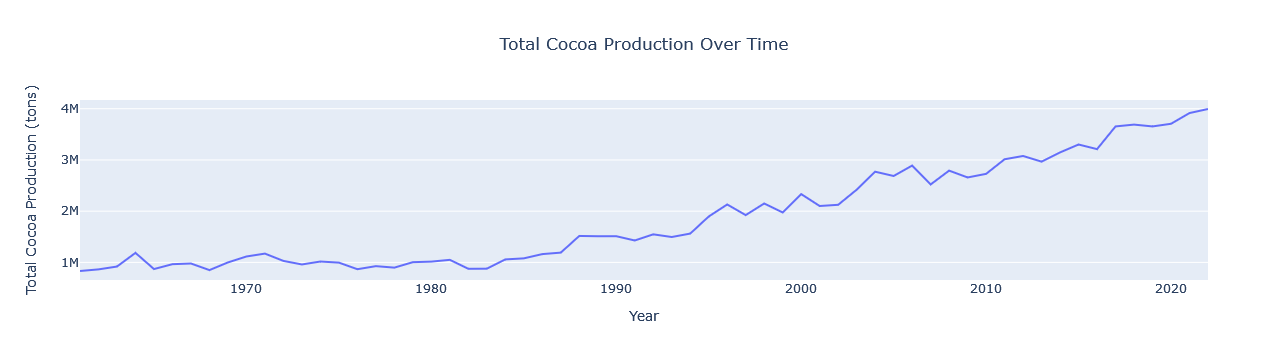

In [58]:
fig = px.line(total_production_df, x='Year', y='Total Production', title='Total Cocoa Production Over Time')

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Total Cocoa Production (tons)',
    title_x=0.5,
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=True),   
)


fig.show()

In [59]:
# Now I need to pivot this and add to the rest. Have the total and different colors as different countries.

pivoted_df.head()

Year,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Cameroon,75100,76000,85000,91200,78800,86500,93000,102000,108186,133770,...,275000,269228,310000,344752,322248,317530,301255,280077,295000,300000
Congo,900,630,800,1100,800,877,1144,1288,1195,1344,...,5000,5000,2500,3800,3500,4500,5000,7000,16000,20000
Côte d'Ivoire,85000,110000,115000,139069,121772,149662,146640,144476,180706,179156,...,1448992,1637778,1796000,1634000,2034000,2113189,2235043,2200000,2228459,2230000
Democratic Republic of the Congo,5800,6500,5600,4800,4300,5300,4900,4500,4900,6200,...,2000,3000,6000,10200,13500,18475,22058,26337,20000,20000
Equatorial Guinea,26000,30900,33000,35100,35400,38200,33600,38000,28000,35000,...,700,892,1000,1000,1000,1000,1000,1000,600,1000


In [74]:
grouped_df = new_df.groupby(["Year", "Country"])["Cocoa Production (tons)"].sum().unstack()


In [75]:
grouped_df.head(10)

Country,Cameroon,Congo,Côte d'Ivoire,Democratic Republic of the Congo,Equatorial Guinea,Gabon,Ghana,Nigeria,Sao Tome and Principe,Sierra Leone,Togo
Year,,,,,,,,,,,
1961,75100,900,85000,5800,26000,3190,415200,197000,9100,2840,11550
1962,76000,630,110000,6500,30900,3360,428100,182000,9600,4780,11400
1963,85000,800,115000,5600,33000,3600,427800,223000,7800,3310,13900
1964,91200,1100,139069,4800,35100,4000,580500,298300,10700,3180,17500
1965,78800,800,121772,4300,35400,2170,415800,184600,8900,2980,14300
1966,86500,877,149662,5300,38200,4296,381100,267200,10900,4534,16300
1967,93000,1144,146640,4900,33600,4061,423500,238000,10900,3869,18338
1968,102000,1288,144476,4500,38000,4751,327000,191800,10600,5039,20000
1969,108186,1195,180706,4900,28000,4366,414300,220800,9100,3782,23600


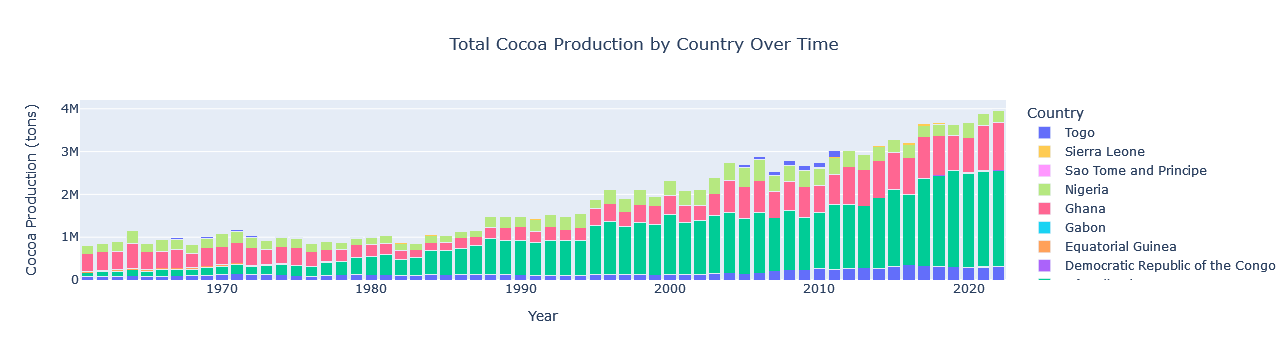

In [76]:
fig = go.Figure()

# Add a bar for each country
for country in grouped_df.columns:
    fig.add_trace(go.Bar(
        x=grouped_df.index,  # Years
        y=grouped_df[country],  # Production values
        name=country  # Country name for the legend
    ))

# Update the layout to stack the bars
fig.update_layout(
    barmode='stack',
    title={'text': "Total Cocoa Production by Country Over Time", 'x': 0.5},
    xaxis_title="Year",
    yaxis_title="Cocoa Production (tons)",
    legend_title="Country",
)

# Show the figure
fig.show()

# Hard to see the lower production countries

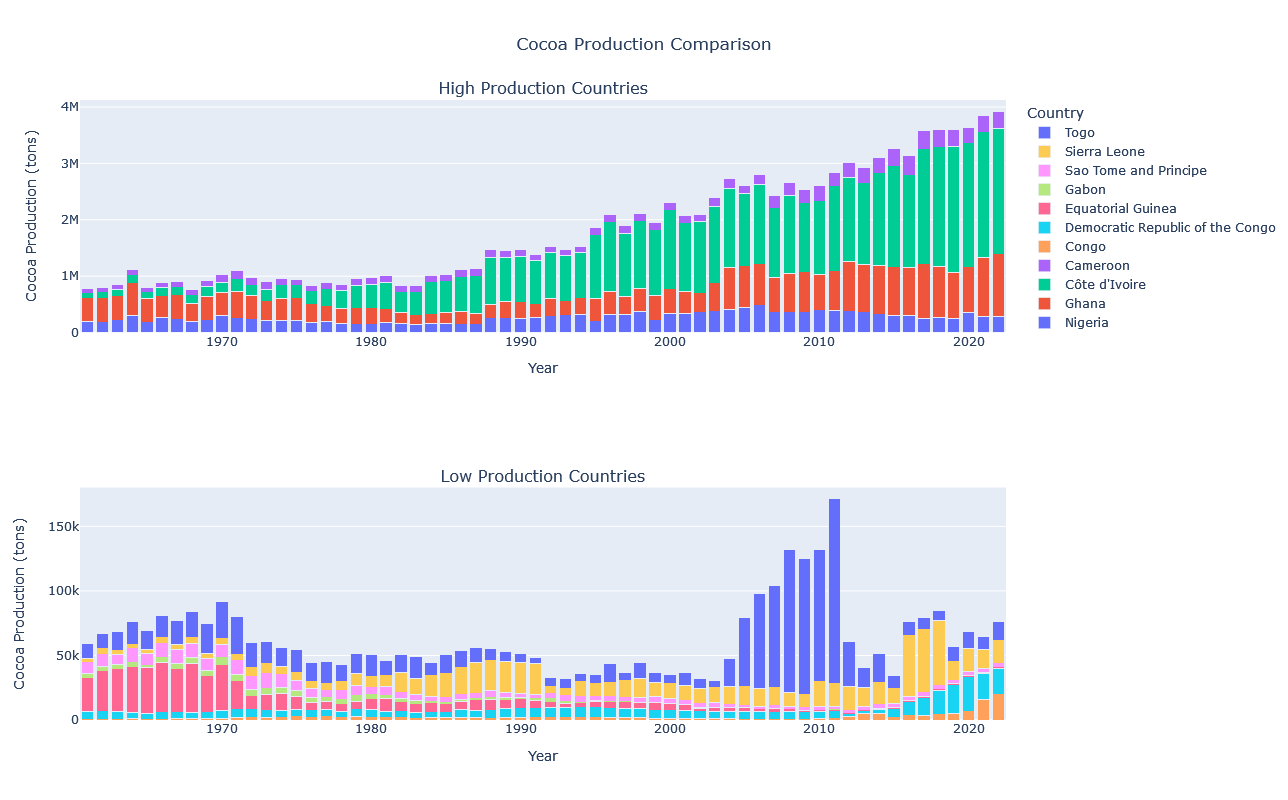

In [78]:
# Need to split the low and high producing countries

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# High production countries list
high_prod_countries = ['Nigeria', 'Ghana', 'Côte d\'Ivoire', 'Cameroon']

# Create the subplot figure with 2 rows for high and low production countries
fig = make_subplots(rows=2, cols=1, subplot_titles=('High Production Countries', 'Low Production Countries'))

# Add the high production countries to the first row of subplots
for country in high_prod_countries:
    fig.add_trace(
        go.Bar(
            x=grouped_df.index,  # The years
            y=grouped_df[country],
            name=country
        ),
        row=1, col=1
    )

# Add the low production countries to the second row of subplots
for country in grouped_df.columns:
    if country not in high_prod_countries:
        fig.add_trace(
            go.Bar(
                x=grouped_df.index,  # The years
                y=grouped_df[country],
                name=country
            ),
            row=2, col=1
        )

# Update the layout to stack the bars
fig.update_layout(
    barmode='stack',
    title={'text': "Cocoa Production Comparison", 'x': 0.5},
    xaxis_title="Year",
    yaxis_title="Cocoa Production (tons)",
    legend_title="Country",
    height=800  # Adjust the height if necessary
)

# Update xaxis properties for both subplots
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)

# Update yaxis properties for both subplots
fig.update_yaxes(title_text="Cocoa Production (tons)", row=1, col=1)
fig.update_yaxes(title_text="Cocoa Production (tons)", row=2, col=1)

# Show the figure
fig.show()

# Blue is used twice need to change it

